In [2]:
import json
import sys
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import defaultdict
import operator
import nltk
from nltk.corpus import stopwords
import string 

YSNO_MAP = set(['is', 'can', 'does', 'are', 'do', 'should', 'did', 'will', 'was', 'has', 'could', 'were', 'would'])
CATEGORIES=set(["Automotive", "Baby", "Beauty", "Cell_Phones_and_Accessories",
                "Clothing_Shoes_and_Jewelry", "Electronics", "Grocery_and_Gourmet_Food",
                "Health_and_Personal_Care", "Home_and_Kitchen", "Musical_Instruments", 
                "Office_Products", "Patio_Lawn_and_Garden", "Pet_Supplies", 
                "Sports_and_Outdoors", "Tools_and_Home_Improvement", "Toys_and_Games", "Video_Games"])


/home/ubuntu/amazon-qar/lib/python3.6/site-packages/matplotlib/font_manager.py:232: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


In [3]:
def getDF(path):
    i = 0
    df = {}
    with open(path, 'r') as fp:
        for line in fp:
            df[i] = json.loads(line)
            i += 1
    
    return pd.DataFrame.from_dict(df, orient='index')

In [5]:
def general_stats_data(df):
    query_type_label = {'YESNO': 0, 'DESCRIPTION':0}
    wfa = 0
    total_judgements = 0
    total_wfa_judgments = 0
    multiple_answers = 0
    multiple_wfa = 0
    total_size = len(df)
    for row in df.iterrows():
        category = row[1]['query_type']
        total_judgements += len(row[1]['answers'])
        currentwfa = row[1]['wellFormedAnswers']
        if category in query_type_label:
            query_type_label[category] += 1
        else:
            print(category)
        if len(row[1]['answers']) > 1:
            multiple_answers += 1
        if currentwfa != '[]':
            wfa += 1
            total_wfa_judgments += len(currentwfa)
            if len(currentwfa) > 1:
                multiple_wfa += 1
    print('Columns:{}'.format(df.columns.values))
    print('{} queries with {} judgements with {} queries contain more than one judgment'.format(total_size,total_judgements,multiple_answers))
    #print('{} queries with Well Formed Answers of which {} contain more than one judgment'.format(wfa,multiple_wfa))
    print('----query distribution by dataset type----')
    for key in query_type_label:
        print(key + ',' + str(query_type_label[key])+ ',' + str(query_type_label[key]/total_size))

In [6]:
def update_query_type(query, query_type, qmap):
    assert len(query) > 0
    query = query.lower()
    head = query.split()[0]
    if query_type == "YESNO":
        qmap['yesno'] += 1
    elif head in qmap:
        qmap[head] += 1
    else:
        qmap['other'] +=1

In [7]:
def compute_query_word_stat(df):
    print('----query distribution by wording----')
    query_type_map = {'yesno':0, 'what':0, 'who':0, 'which':0, 'where':0, 'when':0, 'why':0, 'how':0, 'other':0}
    for row in df.iterrows():
        query = row[1]["query"]
        query_type = row[1]["query_type"]
        update_query_type(query, query_type, query_type_map)
    total = sum(list(query_type_map.values()))
    print(total)
    for k, v in query_type_map.items():
        print('{},{},{}'.format(k, v, 1.0 * v/total))

In [8]:
def compute_first_word_stat(df):
    print('----query first word distribution----')
    query_word_map = defaultdict(int)
    for row in df.iterrows():
        query = row[1]["query"].lower()
        head = query.split()[0]
        query_word_map[head] += 1
    total = sum(list(query_word_map.values()))
    print(total)
    sorted_query_word_freqs = sorted(query_word_map.items(), key=operator.itemgetter(1), reverse=True)
    return sorted_query_word_freqs[:20]

In [9]:
def get_stats(histogram):
    average = 0.0
    total_values = 0.0
    for value in histogram:
        total_values += histogram[value]
        average += float(histogram[value]) * float(value)
    return average/total_values

In [10]:
def generate_histograms(histogram, title):
    average = get_stats(histogram)
    print("###################################\n")
    print("Statistics about {}\n".format(title))
    print("Average length:{}",format(average))
    print("###################################\n")
    plt.bar(list(histogram.keys()), histogram.values(), color='g')
    plt.show()
    #for key in sorted(histogram.keys()):
    #   print("{}:{}".format(key, histogram[key]))

In [11]:
def compute_length_stat(df):
    queries = {}
    answers = {}
    well_formed_answers = {}
    passages = {}

    for row in df.iterrows():
        queries[row[1]['query']] = 1
        for v in row[1]['answers']:
            answers[v] = 1
        for p in row[1]['passages']:
            passages[p['passage_text']] = 1
    data = {'queries' : queries, 'answers' : answers, 'passages' : passages}
    for value in data:
        histogram = {}
        for v in data[value]:
            l = len(v.split())
            if l in histogram:
                histogram[l] += 1
            else:
                histogram[l] = 1
        generate_histograms(histogram, value)

# Load data

In [10]:
data_dir = "/home/ubuntu/Explicable-Question-Answering/data/"

In [11]:
train_infile = data_dir + "train-qar_msmarco_all.jsonl"
train_df = getDF(train_infile)

In [12]:
val_infile = data_dir + "val-qar_msmarco_all.jsonl"
val_df = getDF(val_infile)

test_infile = data_dir + "test-qar_msmarco_all.jsonl"
test_df = getDF(test_infile)

# General Stats

In [13]:
train_df.head(5)

,answers,passages,query,query_id,query_type,wellFormedAnswers
0,"[no it doesn""t, No., It would depend on where ...","[{'is_selected': 1, 'url': '', 'passage_text':...",Does this have a hole that would allow me to p...,206161,DESCRIPTION,[]
1,[I just charged my radios from tues 0902 morni...,"[{'is_selected': 1, 'url': '', 'passage_text':...",How long does it take to charge 2 Two-wave Rad...,614884,DESCRIPTION,[]
2,[Pull behind. The handle likes to fall down. I...,"[{'is_selected': 1, 'url': '', 'passage_text':...",Do you pull or push the caet?,77013,DESCRIPTION,[]
3,[A small child cannot squeeze between the bars...,"[{'is_selected': 1, 'url': '', 'passage_text':...",What is the distance between bars?,43984,DESCRIPTION,[]
4,[I don't think it will work in your computer. ...,"[{'is_selected': 1, 'url': '', 'passage_text':...",Will this work for any DV6 series? Mine is DV6...,404642,DESCRIPTION,[]


In [14]:
general_stats_data(train_df)

Columns:['answers' 'passages' 'query' 'query_id' 'query_type' 'wellFormedAnswers']
455931 queries with 1844868 judgements with 453494 queries contain more than one judgment
----query distribution by dataset type----
YESNO,69816,0.15312843390776235
DESCRIPTION,386115,0.8468715660922377


In [15]:
general_stats_data(val_df)

Columns:['answers' 'passages' 'query' 'query_id' 'query_type' 'wellFormedAnswers']
56895 queries with 229211 judgements with 56578 queries contain more than one judgment
----query distribution by dataset type----
YESNO,8755,0.153879954301784
DESCRIPTION,48140,0.846120045698216


In [16]:
general_stats_data(test_df)

Columns:['answers' 'passages' 'query' 'query_id' 'query_type' 'wellFormedAnswers']
57306 queries with 232575 judgements with 56989 queries contain more than one judgment
----query distribution by dataset type----
YESNO,8807,0.1536837329424493
DESCRIPTION,48499,0.8463162670575507


# Query Stats

In [17]:
compute_query_word_stat(train_df)

----query distribution by wording----
455931
yesno,69816,0.15312843390776235
what,39508,0.08665346291434449
who,208,0.00045620938256008036
which,1561,0.003423763683539834
where,4292,0.00941370514398012
when,1666,0.0036540616891591053
why,2562,0.00561927133711022
how,41171,0.09030094466048591
other,295147,0.6473501472810579


In [18]:
compute_first_word_stat(train_df)

----query first word distribution----
455931


[('does', 69339),
 ('is', 57316),
 ('can', 46277),
 ('will', 41801),
 ('how', 41558),
 ('what', 39835),
 ('i', 33670),
 ('do', 14841),
 ('are', 12923),
 ('would', 7331),
 ('my', 5416),
 ('the', 4948),
 ('where', 4314),
 ('if', 4058),
 ('has', 4013),
 ('this', 3283),
 ("i'm", 2608),
 ('why', 2582),
 ('could', 2217),
 ('when', 2066)]

In [19]:
compute_query_word_stat(val_df)

----query distribution by wording----
56895
yesno,8755,0.153879954301784
what,4836,0.08499868178223043
who,21,0.0003691009754811495
which,212,0.0037261622286668423
where,536,0.009420862993233149
when,221,0.0038843483610159065
why,354,0.00622198787239652
how,5173,0.09092187362685648
other,36787,0.6465770278583355


In [20]:
compute_first_word_stat(val_df)

----query first word distribution----
56895


[('does', 8707),
 ('is', 7117),
 ('can', 5921),
 ('will', 5234),
 ('how', 5221),
 ('what', 4874),
 ('i', 4244),
 ('do', 1969),
 ('are', 1564),
 ('would', 907),
 ('my', 659),
 ('the', 568),
 ('where', 540),
 ('if', 518),
 ('has', 475),
 ('this', 390),
 ('why', 358),
 ("i'm", 356),
 ('could', 285),
 ('when', 260)]

In [21]:
compute_query_word_stat(test_df)

----query distribution by wording----
57306
yesno,8807,0.1536837329424493
what,4872,0.08501727567793949
who,30,0.0005235053921055386
which,173,0.0030188810944752733
where,514,0.008969392384741563
when,200,0.003490035947370258
why,320,0.005584057515792413
how,5222,0.09112483858583743
other,37168,0.6485882804592887


In [22]:
compute_first_word_stat(test_df)

----query first word distribution----
57306


[('does', 8613),
 ('is', 7245),
 ('can', 5900),
 ('will', 5295),
 ('how', 5273),
 ('what', 4918),
 ('i', 4273),
 ('do', 1858),
 ('are', 1591),
 ('would', 938),
 ('my', 758),
 ('the', 620),
 ('has', 525),
 ('where', 517),
 ('if', 507),
 ('this', 401),
 ('why', 325),
 ("i'm", 323),
 ('could', 262),
 ('when', 250)]

# Length Statistics

###################################

Statistics about queries

Average length:{} 14.49969194694131
###################################



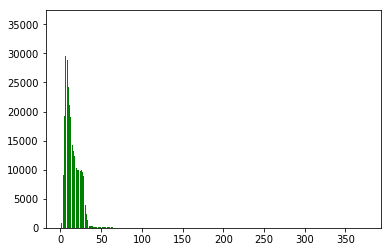

###################################

Statistics about answers

Average length:{} 31.611117798911227
###################################



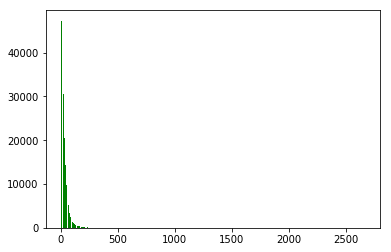

###################################

Statistics about passages

Average length:{} 53.502443481529305
###################################



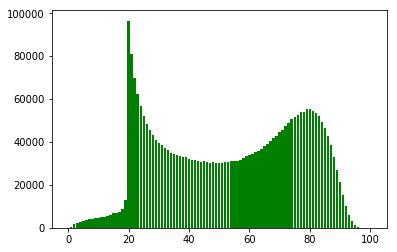

In [23]:
compute_length_stat(train_df)

###################################

Statistics about queries

Average length:{} 14.329882529635789
###################################



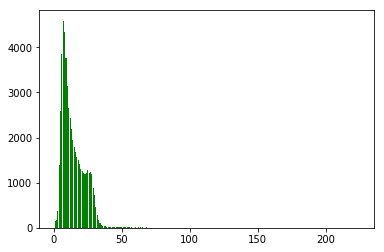

###################################

Statistics about answers

Average length:{} 31.307706643856235
###################################



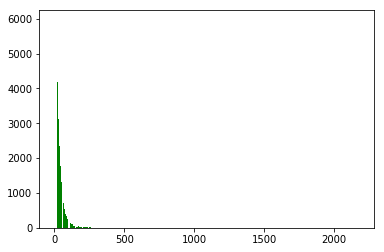

###################################

Statistics about passages

Average length:{} 53.36399816516631
###################################



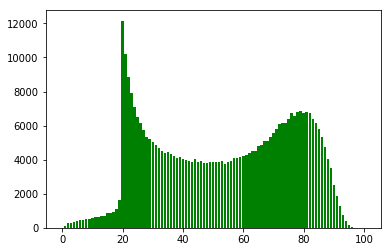

In [24]:
compute_length_stat(val_df)

###################################

Statistics about queries

Average length:{} 14.439009221912258
###################################



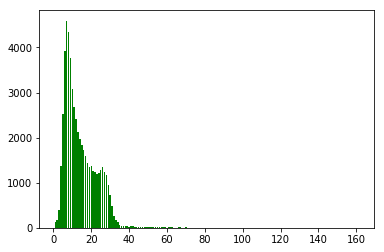

###################################

Statistics about answers

Average length:{} 31.415205998852166
###################################



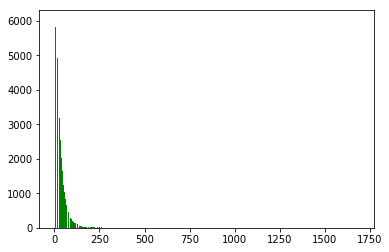

###################################

Statistics about passages

Average length:{} 53.6071017785463
###################################



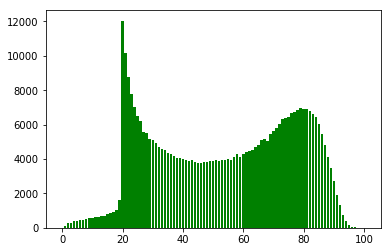

In [25]:
compute_length_stat(test_df)

# Category Analysis

In [15]:
def compute_category_stats(df):
    stats_map = {}
    for cat in CATEGORIES:
        stats_map[cat] = {"#products":set(), "#questions":0, "#answers":0, "#review_snippets": 0, 
                          '#is_answerable': 0, '#yesno':0}
    
    for row in df.iterrows():
        row = row[1]
        if "category" not in row:
            print(row)
            exit(0)
        cat = row["category"]
        stats_map[cat]["#products"].add(row["asin"])
        stats_map[cat]["#questions"] += 1
        stats_map[cat]["#answers"] += len(row["answers"])
        stats_map[cat]["#review_snippets"] += len(row["review_snippets"])
        stats_map[cat]['#is_answerable'] += int(row['is_answerable'])
        if row['questionType'] == 'yesno':
            stats_map[cat]['#yesno'] += 1
        
    print("category #products #questions #answers #review_snippets #is_answerable #yesno")
    for cat in CATEGORIES:
        print("-------------------------------------")
        print("%s %d %d %d %d %d %d" % (cat, len(stats_map[cat]["#products"]), 
                                  stats_map[cat]["#questions"], 
                                  stats_map[cat]["#answers"], 
                                  stats_map[cat]["#review_snippets"],
                                  stats_map[cat]['#is_answerable'],
                                    stats_map[cat]['#yesno']))
    print("-------------------------------------\n")

In [16]:
def compute_answerable_category_stats(df):
    stats_map = {}
    for cat in CATEGORIES:
        stats_map[cat] = {"#questions":0, '#yesno':0}
    
    for row in df.iterrows():
        row = row[1]
        
        if row['is_answerable'] == 1:
            cat = row["category"]
            stats_map[cat]["#questions"] += 1
            if row['questionType'] == 'yesno':
                stats_map[cat]['#yesno'] += 1
        
    print("category #questions #yesno")
    for cat in CATEGORIES:
        print("-------------------------------------")
        print("%s %d %d" % (cat, stats_map[cat]["#questions"], stats_map[cat]['#yesno']))
    print("-------------------------------------\n")
    
    return stats_map

# Load Data

In [12]:
data_dir = "/home/ubuntu/Explicable-Question-Answering/data/"

In [13]:
train_infile = data_dir+"train-qar_all.jsonl"
train_df = getDF(train_infile)

In [18]:
val_infile = data_dir+"val-qar_all.jsonl"
val_df = getDF(val_infile)

test_infile = data_dir+"test-qar_all.jsonl"
test_df = getDF(test_infile)

# General Count Analysis

In [17]:
train_stats_map = compute_answerable_category_stats(train_df)

category #questions #yesno
-------------------------------------
Musical_Instruments 9097 1376
-------------------------------------
Baby 10599 1152
-------------------------------------
Home_and_Kitchen 68655 8380
-------------------------------------
Pet_Supplies 14898 1755
-------------------------------------
Cell_Phones_and_Accessories 28302 6155
-------------------------------------
Tools_and_Home_Improvement 38459 5244
-------------------------------------
Sports_and_Outdoors 44915 7187
-------------------------------------
Health_and_Personal_Care 30554 3870
-------------------------------------
Electronics 113186 18938
-------------------------------------
Beauty 15673 2264
-------------------------------------
Clothing_Shoes_and_Jewelry 3405 462
-------------------------------------
Patio_Lawn_and_Garden 23050 3244
-------------------------------------
Video_Games 4803 905
-------------------------------------
Grocery_and_Gourmet_Food 6997 721
--------------------------------

In [19]:
val_stats_map = compute_answerable_category_stats(val_df)

category #questions #yesno
-------------------------------------
Musical_Instruments 1019 158
-------------------------------------
Baby 1210 136
-------------------------------------
Home_and_Kitchen 8496 1080
-------------------------------------
Pet_Supplies 1919 232
-------------------------------------
Cell_Phones_and_Accessories 3601 794
-------------------------------------
Tools_and_Home_Improvement 4862 701
-------------------------------------
Sports_and_Outdoors 5888 901
-------------------------------------
Health_and_Personal_Care 3701 461
-------------------------------------
Electronics 13642 2238
-------------------------------------
Beauty 1919 274
-------------------------------------
Clothing_Shoes_and_Jewelry 388 50
-------------------------------------
Patio_Lawn_and_Garden 2704 399
-------------------------------------
Video_Games 711 140
-------------------------------------
Grocery_and_Gourmet_Food 1064 96
-------------------------------------
Automotive 2950 62

In [20]:
test_stats_map = compute_answerable_category_stats(test_df)

category #questions #yesno
-------------------------------------
Musical_Instruments 1095 170
-------------------------------------
Baby 1372 137
-------------------------------------
Home_and_Kitchen 8603 1031
-------------------------------------
Pet_Supplies 2066 267
-------------------------------------
Cell_Phones_and_Accessories 3636 766
-------------------------------------
Tools_and_Home_Improvement 4819 654
-------------------------------------
Sports_and_Outdoors 5808 962
-------------------------------------
Health_and_Personal_Care 3790 492
-------------------------------------
Electronics 14054 2381
-------------------------------------
Beauty 1932 263
-------------------------------------
Clothing_Shoes_and_Jewelry 364 47
-------------------------------------
Patio_Lawn_and_Garden 2899 400
-------------------------------------
Video_Games 634 113
-------------------------------------
Grocery_and_Gourmet_Food 864 108
-------------------------------------
Automotive 2893 61

In [21]:
all_stats_map = {}
for cat in CATEGORIES:
    all_stats_map[cat] = {"#questions":0, '#yesno':0}
        
for cat in CATEGORIES:
    all_stats_map[cat]['#questions'] = train_stats_map[cat]['#questions'] + val_stats_map[cat]['#questions'] + test_stats_map[cat]['#questions']
    all_stats_map[cat]['#yesno'] = train_stats_map[cat]['#yesno'] + val_stats_map[cat]['#yesno'] + test_stats_map[cat]['#yesno']


In [47]:
xlabels = CATEGORIES
yesno = []
desc = []
for cat in xlabels:
    y = all_stats_map[cat]['#yesno']
    yesno.append(y)    
    desc.append(all_stats_map[cat]['#questions'] - y)

In [48]:
from matplotlib import pyplot as plt

In [49]:
alls = list(zip(yesno, desc, cats))
alls

[(1704, 9507, 'Musical Instruments'),
 (1425, 11756, 'Baby'),
 (10491, 75263, 'Home and Kitchen'),
 (2254, 16629, 'Pet Supplies'),
 (7715, 27824, 'Cell Phones and Accessories'),
 (6599, 41541, 'Tools and Home Improvement'),
 (9050, 47561, 'Sports and Outdoors'),
 (4823, 33222, 'Health and Personal Care'),
 (23557, 117325, 'Electronics'),
 (2801, 16723, 'Beauty'),
 (559, 3598, 'Clothing Shoes and Jewelry'),
 (4043, 24610, 'Patio Lawn and Garden'),
 (1158, 4990, 'Video Games'),
 (925, 8000, 'Grocery and Gourmet Food'),
 (5952, 23076, 'Automotive'),
 (3624, 21329, 'Toys and Games'),
 (3166, 18750, 'Office Products')]

In [50]:
alls = sorted(alls, key=lambda kv: kv[1]+kv[0])

In [51]:
yesno, desc, cats = zip(*alls)

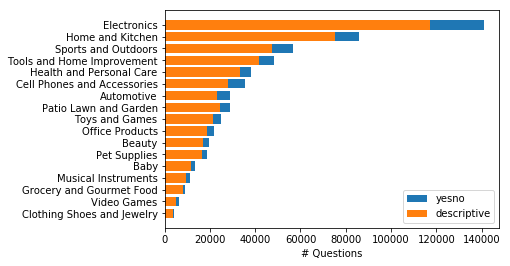

In [52]:
f = plt.figure()

cats = [x.replace("_", " ") for x in cats]

ind = range(len(xlabels))
plt.yticks(ind, cats)
plt.xlabel('# Questions')
p1 = plt.barh(ind, yesno, left=desc)
p2 = plt.barh(ind, desc)

plt.legend( (p1[0], p2[0]), ('yesno', 'descriptive') )

plt.show()
f.savefig("question_type.pdf", bbox_inches='tight')

# Full Category Analysis

In [19]:
def compute_full_category_stats(df, cat):
    stats_map = {}
    stats_map[cat] = {"#products":set(), "#questions":0, "#answers":0, "#reviews": 0}
    
    for row in df.iterrows():
        row = row[1]
        stats_map[cat]["#products"].add(row["asin"])
        for question in row["questions"]:
            stats_map[cat]["#questions"] += 1
            stats_map[cat]["#answers"] += len(question["answers"])
        stats_map[cat]["#reviews"] += len(row["reviews"])
    
    print("category                  #products #questions #answers #reviews")
    print("-------------------------------------")
    print("%s %d %d %d %d" % (cat, len(stats_map[cat]["#products"]), 
                              stats_map[cat]["#questions"], 
                              stats_map[cat]["#answers"], 
                              stats_map[cat]["#reviews"]))
    print("-------------------------------------\n")

In [ ]:
for cat in CATEGORIES:
    infile = data_dir+"qar_products_"+cat+".jsonl"
    df = getDF(infile)
    compute_full_category_stats(df, cat)

In [ ]:
# Utils

In [ ]:
def convert(infile, outfile):
    rfp = open(infile, 'r')
    wfp = open(outfile, 'w')
    
    for line in rfp:
        final_json = json.loads(line)
        if len(final_json["context"].split(' ')) == 0:
            continue
        wfp.write(line)
    wfp.close()

In [ ]:
data_dir = "/Users/rchanda/Acads/Fall-2018/Capstone/Explicable-Question-Answering/data/old/"
infile = data_dir+"val-qar_squad_all.jsonl"
outfile = data_dir+"val-qar_squad_all.jsonl_new"
convert(infile, outfile)

# Span Analysis

In [10]:
def process_text(text):
    punctuations = string.punctuation.replace("\'", '')

    for ch in punctuations:
        text1 = text.replace(ch, "")

    tokens = text1.split()
    
    for i, token in enumerate(tokens):
        if not token.isupper():
            tokens[i] = token.lower()
    return ' '.join(tokens)

In [11]:
def get_all_spans(input_file):
    all_spans = []

    rfp = open(input_file, 'r')
    for line in tqdm(rfp):
        row = json.loads(line)
        spans = row["qas"][0]["answers"]
        for span in spans:
            text = process_text(span["text"])
            all_spans.append(text)
    
    return all_spans

In [12]:
data_dir = "/home/ubuntu/Explicable-Question-Answering/data/"
input_file = data_dir+"val-qar_squad_all.jsonl"

In [13]:
all_spans = get_all_spans(input_file)

56895it [00:03, 14782.71it/s]


In [14]:
def get_span_stats(all_spans):
    word_freqs = defaultdict(int)
    span_lens = defaultdict(int)
    span_freqs = defaultdict(int)
    
    for text in all_spans:
        span_freqs[text] += 1
        
        tokens = text.split()
        span_lens[len(tokens)] += 1
        for word in tokens:
            word_freqs[word] += 1
    
    generate_histograms(span_lens, "span_lens")
    return word_freqs, span_freqs

###################################

Statistics about span_lens

Average length:{} 6.572816591967659
###################################



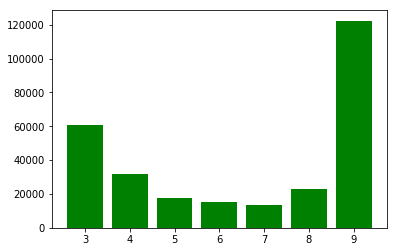

In [15]:
word_freqs, span_freqs = get_span_stats(all_spans)

In [16]:
sorted_word_freqs = sorted(word_freqs.items(), key=operator.itemgetter(1), reverse=True)

In [17]:
sorted_word_freqs[:50]

[('the', 158023),
 ('I', 72132),
 ('to', 66565),
 ('it', 65445),
 ('a', 64455),
 ('and', 64076),
 ('is', 50478),
 ('of', 34254),
 ('for', 30587),
 ('have', 28608),
 ('this', 28375),
 ('on', 25985),
 ('with', 25802),
 ('in', 25625),
 ('my', 22693),
 ('you', 18083),
 ('that', 17822),
 ('not', 17456),
 ('but', 14369),
 ('use', 12797),
 ('are', 11249),
 ('was', 10412),
 ('be', 9246),
 ('as', 9038),
 ('they', 8224),
 ('can', 7878),
 ('very', 7600),
 ('so', 7426),
 ('if', 7374),
 ('would', 7250),
 ('one', 6546),
 ('had', 6288),
 ('will', 5858),
 ('get', 5380),
 ('used', 5257),
 ('great', 5218),
 ('work', 5006),
 ('bought', 4914),
 ('like', 4695),
 ('at', 4658),
 ('has', 4599),
 ('just', 4576),
 ('up', 4513),
 ("don't", 4494),
 ('fit', 4338),
 ('does', 4327),
 ('out', 4263),
 ('these', 4249),
 ('from', 4156),
 ('when', 4084)]

In [18]:
sorted_span_freqs = sorted(span_freqs.items(), key=operator.itemgetter(1), reverse=True)

In [19]:
sorted_span_freqs[:100]

[('it is a', 434),
 ('I have a', 363),
 ('this is a', 334),
 ('and it is', 241),
 ('I have to', 169),
 ('out of the', 147),
 ('I use it', 145),
 ('and I have', 121),
 ('this is the', 117),
 ('it is not', 117),
 ('is a great', 116),
 ('I bought this', 110),
 ('you have to', 105),
 ('but it is', 105),
 ('I had to', 105),
 ('it does not', 104),
 ('it has a', 102),
 ('one of the', 101),
 ('a lot of', 86),
 ('it in the', 85),
 ('if you have', 84),
 ('comes with a', 81),
 ('it is very', 79),
 ('if you are', 75),
 ('and it works', 75),
 ('and they are', 74),
 ('I have used', 73),
 ('that it is', 73),
 ('I have had', 72),
 ('I have the', 70),
 ('there is a', 70),
 ('come with a', 63),
 ('and it was', 63),
 ('that I have', 55),
 ('it on the', 54),
 ('I have not', 53),
 ('is a very', 52),
 ('it is the', 51),
 ("I don't know", 50),
 ('is a little', 50),
 ('I do not', 50),
 ('to be a', 49),
 ('is a good', 48),
 ('and it does', 48),
 ('you need to', 48),
 ('it was a', 48),
 ('I have been', 46),
 ('

In [2]:
data_dir = "/home/ubuntu/Explicable-Question-Answering/data/"

In [11]:
prods_infile = data_dir+"test-qar_products_all.jsonl"
num_products = 0
num_reviews = 0
num_questions = 0
num_answers = 0

with open(prods_infile, 'r') as fp:
    for line in fp:
        row = json.loads(line)
        num_products += 1
        for question in row["questions"]:
            num_questions += 1
            num_answers += len(question["answers"])
        num_reviews += len(row["reviews"])

In [8]:
print(num_products, num_reviews, num_questions, num_answers)

156065 14306887 923787 3624320


In [7]:
# train
print(num_products, num_reviews, num_questions, num_answers)

124852 11431192 738861 2899240


In [10]:
# val
print(num_products, num_reviews, num_questions, num_answers)

15606 1403958 92192 360629


In [12]:
# test
print(num_products, num_reviews, num_questions, num_answers)

15607 1471737 92734 364451
